# Lección 2.3: Sistemas de varios qubits

En esta lección consideraremos sistemas de 2 o más qubits. Introduciremos el formalismo del operador densidad para describir el estado de un qubit particular de un registro cuántico cuando este último se encuentra en un estado entrelazado. Aprenderemos a generar entrelazamiento por medio de la compuerta CNOT. Posteriormente, introduciremos el famoso teorema de no clonación, y sus implicaciones para la computación. Finalmente, veremos un ejemplo práctico sobre el uso de estados entrelazados y el formalismo de la matriz densidad para construir un **duplicador universal**, siguiendo el trabajo de Buzek y Hillery.

**SUPER IMPORTANTE:** En este ejemplo intentaremos presentar al lector el formalismo necesario para estudiar la computación cuántica en forma teórica, así como una posible intuición física sobre la misma. Esta sesióne stá disponible en nuestro servidor de MyBinder.

<p align=center>
  <a href="https://mybinder.org/v2/gh/QC-FEM/QC-CrashCourse/HEAD">
    <img src="https://mybinder.org/badge_logo.svg">
  </a>
</p>

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, BasicAer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
backend = Aer.get_backend('statevector_simulator')

## Estados de varios qubits

Como vimos en lecciones anteriores, podremos describir un sistema cuántico compuesto empleando el **producto tensorial o de Kroenecker**. Este nos permitirá definir una *base* para los estados de un sistema compuesto. Por ejemplo, un registro de $N$ qubits, puede descrbirse en términos de la *base computacional*

$$|q_{N-1} \ldots q_2q_1q_0\rangle = |q_{N-1}\rangle \otimes \ldots \otimes |q_2\rangle \otimes |q_1\rangle \otimes |q_0\rangle$$

Donde $q_i = 0,1$. Es importante notar que la base computacional de un registro de $N$ qubits es numerable. De hecho, si interpretamos la secuencia de valores $q_i$ como una cadena binaria, esta no es más que la representación en sistema binario de un número entre $0$ y $2^{N}-1$. Por ejemplo, si consideramos un registro de 3 qubits, entonces podremos establecer las siguientes equivalencias

$$|1\rangle \otimes |0\rangle \otimes |1\rangle = |101\rangle = |9\rangle$$

En lenguaje matricial, la base computacional corresponde a la base estándar de un espacio vectorial complejo de dimensión $2^{N}$. Siguiendo con el ejemplo anterior, es posible realizar la equivalencia

$$|k\rangle = \begin{bmatrix}0 \\ \vdots \\ 1 \\ \vdots \\ 0\end{bmatrix} \rightarrow \text{ en la }k\text{-ésima posición}$$

Para $0 \leq k \leq 2^{N}-1$. 

>El estado general de un registro cuántico de $N$ qubits puede representarse como una combinación lineal de los estados de la base computacional
>
>$$|\psi\rangle = \sum_{k = 0}^{2^{N}-1}\alpha_k |k\rangle$$

Los coeficientes de la expansión pueden tener una interpretación probabilística. En el caso de estados de un qubit, recordemos, estos presentaban información sobre la probabilidad de medir un valor de bit $0$ o $1$. Para un registro cuántico, estos dan información sobre la probabilidad de medir una cadena binaria particular, representable con $N$ bits. 

>Es decir, si se define $p(k|\psi)$ como la probabilidad de medir una cadena binaria que representa el entero $k$, dado que el registro está en un estado cuántico $|\psi\rangle$, entonces
>
>$$p(k|\psi) = |\alpha_k|^2$$

## Compuertas de varios qubits

Al considerar la computación reversible vimos varias compuertas que actúan sobre 2 o 3 qubits. En su momento, presentamos la acción sobre cualquier cadena binaria particular. La generalización a la computación cuántica se produce por medio de la definición de operadores lineales que tienen el mismo efecto que las compuertas reversibles consideradas sobre la base computacional. Por ejemplo, consideremos la compuerta CNOT. EN computación cuántica, esta serñá representada por un *operador lineal*, que denotaremos con $CNOT$. Como vimos en su momento, esta compuerta se define por

$$CNOT |00\rangle = |00\rangle$$

$$CNOT |01\rangle = |01\rangle$$

$$CNOT |10\rangle = |11\rangle$$

$$CNOT |11\rangle = |10\rangle$$

Donde asumimos que el bit menos significativo es el objetivo, y el más significativo, el de control. Podremos entonces representar la compuerta CNOT por medio de una matriz. Invitamos al lector a convencerse que esta es

$$CNOT = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{bmatrix}$$

Invitamos al lector a encontrar la representación matricial de la compuerta CNOT cuando el bit objetivo es el más significativo y el menos significativo, el de control. Para ello deberá considerar la acción de esta como un operador sobre la base computacional.

## Estados independientes y estados entrelazados

Consideremos un registro cuántico de 2 qubits, inicializado en el estado $|00\rangle$. Vamos a realizar dos tipos de operaciones sobre este. En un primer lugar, vamos a aplicar una rotación de un qubit sobre cada qubit del registro. Estas corresponderán a las conocidas compuertas de Hadmard y Pauli X. Posteriormente, vamos a realizar una rotación de un qubit (compuerta Hadamard) sobre alguno de los qubits del registro; luego aplicaremos una compuerta CNOT utilizando el qubit rotado como control. Vamos a comparar ambas situaciones en términos de probabilidades condicionales. Definiremos la siguiente notación: diremos que $p(q_i = a)$ denota la probabilidad que $q_i$ tenga un valor de bit $a$; mientras que $p(q_i = a | q_j = b)$ denota la probabilidad que $q_i$ tenga un valor de bit $a$, dado que fue medido que $q_j$ tiene un valor de bit $b$.

**SUPER IMPORTANTE:** En el contexto de la teoría de la probabilidad, definimos la *probabilidad condicional* de ocurrencia de un evento $A$, dado otro evento $B$, por medio de la expresión

$$p(A|B) = \frac{p(A \bigcap B)}{p(B)}$$

Diremos entonces que dos eventos son *independientes* si $p(A|B) = P(A)$. Para los efectos de esta lección, si dos eventos son independientes, la ocurrencia de uno no guarda correlación con la ocurrencia del otro.

### Circuito independiente

Vamos a considerar la primera situación. Con qiskit vamos a encontrar la probabilidad de que el bit $q_1$ tenga valor 1, dado que se mide un valor particular de $q_0$. Vamos a definir el circuito base

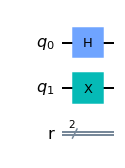

In [2]:
## Creamos registro cuántico
q = QuantumRegister(2,name='q')
## Creamos registro de medición
r = ClassicalRegister(2,name='r')
QC_indep = QuantumCircuit(q,r)
## Aplicamos Hadmard Sobre q0
QC_indep.h(q[0])
## Aplicamos X sobre q1
QC_indep.x(q[1])
## Dibujamos el circuito
QC_indep.draw(output='mpl')

Vamos a establecer $p(q_0 = 0)$. Para ello, vamos a simular el circuito, y guardar solo la medición del bit $q_0$

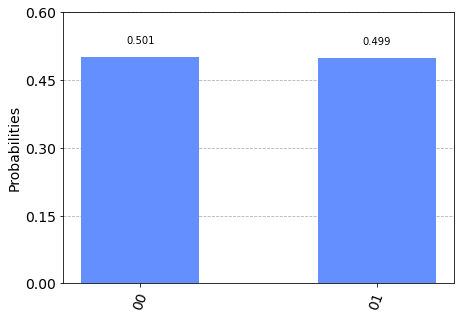

In [3]:
qasm_sim = BasicAer.get_backend('qasm_simulator')
QC_indep.measure(q[0],r[0])
counts = execute(QC_indep,qasm_sim,shots=1<<15).result().get_counts()
plot_histogram(counts)

Notamos inmediatamente que $p(q_0 = 0) = 0.5$. Igualmente, $p(q_0 = 1) = 0.5$. En forma análoga, podemos determinar que $p(q_1 = 0) = 0$, $p(q_1 = 1) = 1$. Ahora podremos determinar las probabilidades $p(q_0 = a \bigcap q_1 = b)$. Esto lo realizamos midiendo ambos valores de bit al tiempo

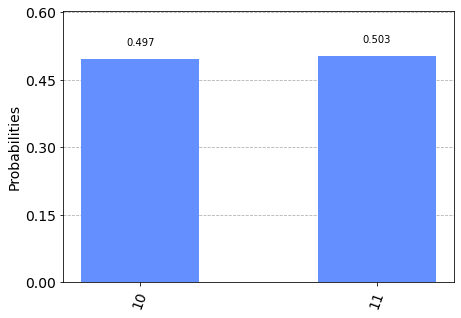

In [4]:
## Ejecutamos el circuito
qasm_sim = BasicAer.get_backend('qasm_simulator')
QC_indep.measure(q,r)
counts = execute(QC_indep,qasm_sim,shots=1<<15).result().get_counts()
plot_histogram(counts)

Con el simulador notamos que $p(q_0 = 0 \bigcap q_1 = 1) = 0.5$ y $p(q_0 = 1 \bigcap q_1 = 1) = 0.5$. Con estos datos, invitamos al lector a convencerse de que

$$p(q_1 = 1 | q_0 = 0) = p(q_1 = 1 | q_0 = 1) = 1 = p(q_1 = 1)$$

$$p(q_1 = 0 | q_0 = 0) = p(q_1 = 0 | q_0 = 1) = 0 = p(q_1 = 0)$$

De igual forma si $q_0 = 1$. En esta situación observamos que no existe una correlación entre la medición del valor de bit de $q_0$, y aquella de $q_1$. Decimos que con este circuito hemos contruido un **estado separable o independiente**

> En un estado separable, no hay una correlación entre los observables de un subsistema u otro. Cada qubit de un registro cuántico descrito por un estado separable está descrito por una distribución de probabilidad independiente de los otros. Matemáticamente, un estado separable está descrito por medio de un **producto de Kroenecker**
>
> $$|\psi\rangle = |\psi_{N-1}\rangle \otimes \cdots \otimes |\psi_{2}\rangle \otimes |\psi_{1} \rangle \otimes |\psi_{0}\rangle$$

### Circuito entrelazado

Repetiremos el procedimiento anterior, pero esta vez utilizaremos una compuerta CNOT, en lugar de una compuerta X de Pauli. Definimos el circuito base

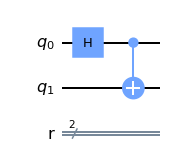

In [17]:
## Creamos registro cuántico
q = QuantumRegister(2,name='q')
## Creamos registro de medición
r = ClassicalRegister(2,name='r')
QC_ent = QuantumCircuit(q,r)
## Aplicamos Hadmard Sobre q0
QC_ent.h(q[0])
## Aplicamos X sobre q1
QC_ent.cx(*q)
## Dibujamos el circuito
QC_ent.draw(output='mpl')

Al igual que antes, calcularemos $p(q_0 = 0)$ y $p(q_1 = 1)$. Para ello solo mediremos el valor de bit de $q_0$

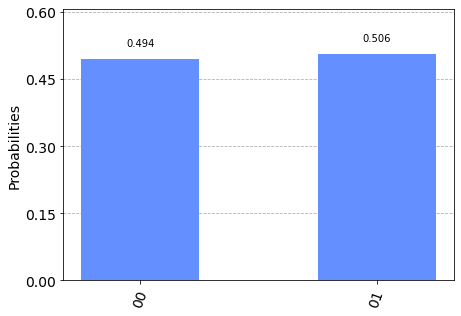

In [6]:
qasm_sim = BasicAer.get_backend('qasm_simulator')
QC_ent.measure(q[0],r[0])
counts = execute(QC_ent,qasm_sim,shots=1<<15).result().get_counts()
plot_histogram(counts)

Igual que antes, identificamos que $p(q_0 = 0) = p(q_1 = 1) = 0.5$. De igual forma determinamos que $p(q_1 = 0) = p(q_1 = 1) = 0.5$. Ahora procedemos a calcular $p(q_0 = a \bigcap q_1 = b)$, midiendo el bit de ambos qubits al tiempo.

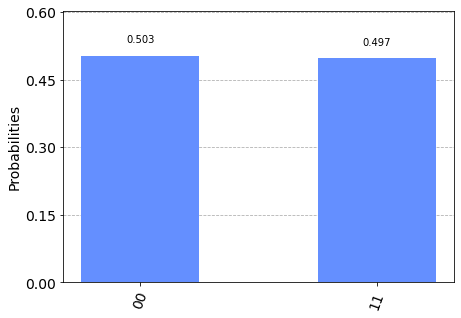

In [7]:
## Ejecutamos el circuito
qasm_sim = BasicAer.get_backend('qasm_simulator')
QC_ent.measure(q,r)
counts = execute(QC_ent,qasm_sim,shots=1<<15).result().get_counts()
plot_histogram(counts)

Notamos inmediatamente que $p(q_1 = 1 \bigcap q_0 = 1) = p(q_1 = 0 \bigcap q_0 = 0) = 0.5$. En consecuencia, podremos advertir que

$$p(q_1 = 0 | q_0 = 0) = 1 \neq p(q_1 = 0)$$

$$p(q_1 = 1 | q_0 = 1) = 1 \neq p(q_1 = 1)$$

Es decir, existe una correlación entre las mediciones del valor de bit de ambos qubits. Notaremos que estas están **directamente correlacionadas**. Siempre que se mida un valor de bit en $q_0$, $q_1$ tendrá el mismo valor de bit. Esto no es un hecho extraño de la física clásica. De hecho, las interacciones entre sistemas, como aquella que es representada por la compuerta CNOT, tienden a construir correlaciones entre sistemas interactuantes. Sin embargo, sistemas cuánticos como el que acabamos de considerar en el circuito anterior tienen correlaciones mucho más altas que aquellas predichas por teorías basadas en los paradigmas de la física clásica. Esta propiedad, y otras que discutiremos en futuras lecciones, son una manifestación de una propiedad cuántica que denominaremos **entrelazamiento**.

> Un estado entrelazado es aquel en el cual el vector de estado del registro cuántico no puede expresarse como un producto de Kroenecker de vectores de estado de los componentes individuales. Esto es una manera de decir que existen correlaciones entre las distintas cantidades medibles asociadas a cada qubit del mismo, y que son producto de su naturaleza cuántica.

### Descripción matemática

Vamos ahora a analizar este simple ejemplo utilizando el formalismo matemático de la mecánica cuántica. Para ello, recordemos que podremos describir la acción de dos compuertas que actúan sobre un qubit por medio del producto de Kroenecker. Supongamos que tenemos compuertas $\hat{U}_{N-1}$, $\hat{U}_{N-2}$, $\ldots$, $\hat{U}_0$, actuando sobre los qubits un registro, que se encuentra en un estado de la base computacional $|q_{N-1}\cdots q_0\rangle$. Cada compuerta actúa sobre un qubit solamente. Diremos entonces que la acción de este conjunto de compeurtas sobre el estado del registro es

$$(\hat{U}_{N-1} \otimes \hat{U}_{N-2} \otimes \cdots \otimes \hat{U}_{1} \otimes \hat{U}_{0}) |q_{N-1}\cdots q_0\rangle = |\psi_{N-1}\rangle \otimes |\psi_{N-2}\rangle \otimes \cdots \otimes |\psi_0\rangle$$

Donde realizamos la definición

$$|\psi_i\rangle = \hat{U}_{i}|q_i\rangle$$

#### Circuito independiente

Utilizando la notación anterior, podremos ver que el estado del registro de 2 qubits después de ejecutar el circuito es

$$|\psi_f\rangle = (\hat{X} \otimes \hat{H})|00\rangle$$

Invitamos al lector a demostrar que este corresponde a

$$|\psi_f\rangle = \frac{1}{\sqrt{2}}(|10\rangle + |11\rangle)$$

Notaremos que este es fácilmente factorizable como

$$|\psi_f\rangle = |1\rangle \otimes |+\rangle$$

Donde identificamos el estado $|+\rangle$ que conocimos en lecciones anteriores. Más adelante, cuando discutamos el tratamiento de la medición en mecánica cuántica, notaremos que en este estado los observables asociados únicamente al qubit 0, no guardan una correlación con aquellos del qubit 1. Esto se expresa matemáticamente en el hecho que puede expresarse como un producto de Kroenecker.

#### Circuito entrelazado

Utilizando la notación anterior, podremos ver que el estado del sistema antes de aplicar la compuerta CNOT es un estado producto

$$|\psi \rangle = |0\rangle \otimes |+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$$

> La compuerta CNOT cuántica actúa como un operador lineal. Recordando que el control es el bit menos significativo, identificamos que el estado final del registro es
>
> $$|\psi_f\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$
>
> Invitamos al lector a demostrar que este es un estado **entrelazado**

La clave es la compuerta CNOT. Esta es fundamental para crear entrelazamiento en el estado de un registro. Existe una gran cantidad de compuertas de 2 qubits que pueden cumplir esta función. Sin embargo, CNOT tiene la propiedad de ser parte de un conjunto universal de compuertas para la computación cuántica. Ya que, en el momento de construcción de este curso, los dispositivos de IBM Q utilizan esta compuerta para transpilar algoritmos cuánticos digitales, no entraremos en detalles sobre las propiedades de otras compuertas entrelazantes, a menos que sea estrictamente necesario.

> Los estados entrelazados permiten codificar más información que los estados puros.

## Propagación de Fase

Esta es una técnica que suele utilizarse ampliamente en el desarrollo de algoritmo cuánticos. Lo veremos más adelante en algoritmos como el de Deutsch-Joza. Consideremos un sistema de dos qubits, y una compuerta cuántica $\hat{U}$, que actúa sobre un qubit. Definimos una compuerta controlada $C(U)$, que actúa sobre nuestro registro de dos qubits

$$C(U)|\psi\rangle \otimes |0\rangle = |\psi\rangle \otimes |0\rangle$$

$$C(U)|\psi\rangle \otimes |1\rangle = (\hat{U}|\psi\rangle) \otimes |1\rangle$$

Diremos que el qubit menos significativo (el de la derecha) es el **qubit de control**, mientras que el qubit más significativo será denominado el **qubit objetivo**. Así, por ejemplo, la compuerta CNOT es equivalente a la compuerta $C(X)$. Imaginemos que preparamos el qubit objetivo en un *autoestado* de la compuerta $\hat{U}$

$$\hat{U}|u\rangle = \mathrm{e}^{-\mathrm{i}\phi}|u\rangle$$

En este caso, a partir de la definición de $C(U)$, tendremos que

$$C(U)|u\rangle \otimes |0\rangle = |u\rangle \otimes |0\rangle$$

$$C(U)|u\rangle \otimes |1\rangle = |u\rangle \otimes (\mathrm{e}^{-\mathrm{i}\phi}|1\rangle)$$

Si el qubit control se encuentra en un estado superposición $|\psi\rangle$, y considerando la definición de los operadores de rotación que vimos anteriormente, entonces

$$C(U)|u\rangle \otimes |\psi\rangle = \mathrm{e}^{-\mathrm{i}\frac{\phi}{2}}(|u\rangle \otimes R_z(\phi)|\psi\rangle)$$

> Salvo una fase global, al preparar el qubit objetivo en un *autoestado* de una compuerta, podemos rotar el vector de estado del qubit control (con respecto al eje z), un ángulo que depende de la fase asociada al autovalor del autoestado del qubit objetivo. De una forma más directa, si el estado del qubit de control es
>
> $$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$
>
> Entonces al aplicar una compuerta $C(U)$, con un objetivo preparado en un autoestado con fase asociada $\phi$, el estado del control rotará a
>
> $$\alpha|0\rangle + \beta\mathrm{e}^{-\mathrm{i}\phi}|1\rangle$$

### Ejemplo con CNOT

A partir de nuestra discusión sobre rotaciones de un qubit, sabemos que los autoestados de la compuerta $X$ de Pauli son

$$\hat{X}|+\rangle = \mathrm{e}^{-\mathrm{i}2\pi} |+\rangle = |+\rangle$$

$$\hat{X}|-\rangle = \mathrm{e}^{-\mathrm{i}\pi} |-\rangle = -|-\rangle$$

Veremos entonces que aplicar una compuerta CNOT con un control en un estado superposición, y un control en un estado de la base de signo, rota el estado del control en un ángulo $2\pi$ o $\pi$, dependiendo del estado del objetivo.

#### Demostración con control en $|-\rangle$

Vamos a preparar nuestro qubit de control en un estado cuyo vector de Bloch está descrito por ángulos $\theta = \pi/4$, $\phi = 0$. Iniciaremos el qubit objetivo en el estado

$$|-\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$$

/Users/diegoherrerarojas/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


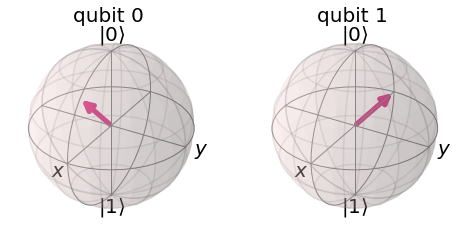

In [11]:
## Iniciamos el estado del qubit control
control = np.array([np.cos(np.pi/8),np.sin(np.pi/8)])
## Iniciamos el estado del qubit objetivo
objetivo = np.array([np.cos(np.pi/4),-np.sin(np.pi/4)])
## Estado conjunto
init = np.kron(objetivo,control)
## Dibujamos el estado inicial de los qubits
plot_bloch_multivector(init)

Procederemos a aplicar una compuerta CNOT y observar la rotación del qubit objetivo. Para ello, utilizaremos ```initialize``` para cargar el estado inicial del registro.

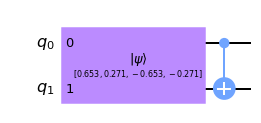

In [14]:
## Declaramos el circuito
DemoFase = QuantumCircuit(2)
## Cargamos el estado inicial
DemoFase.initialize(init)
## Aplicamos CNOT
DemoFase.cx(0,1)
## Dibujamos el circuito
DemoFase.draw(output='mpl')

/Users/diegoherrerarojas/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


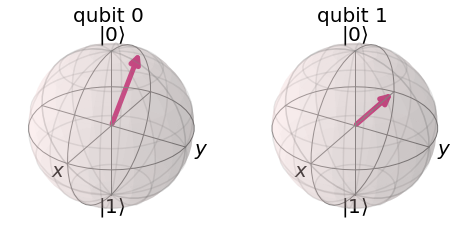

In [15]:
## Ejecutamos el circuito
vec_fin = execute(DemoFase,backend).result().get_statevector()
## Dibujamos el vector de estado
plot_bloch_multivector(vec_fin)

## Teorema de no clonación

Consideremos un problema sencillo pero fundamental de la computación: copiar el valor de una variable, en otra. En computación clásica reversible identificamos que la compuerta CNOT nos permite realizar esta tarea. De hecho, si trabajamos excvlusivamente con estados de la base computacional, obtenemos dos copias completamente independientes, que se encuentran en el mismo estado. Consideremos ahora la tarea de duplicar el estado de un qubit

$$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$

En otro qubit, preparado en un estado de referencia $|Q\rangle$. Supongamos que exista un circuito (representado como un operador unitario de 2 qubits $\hat{U}$) que pueda actuar sobre la base computacional, de forma que

$$\hat{U}|0\rangle \otimes |Q\rangle = |0\rangle \otimes |0\rangle$$

$$\hat{U}|1\rangle \otimes |Q\rangle = |1\rangle \otimes |1\rangle$$

Puesto que los operadores correspondientes a circuitos cuánticos **son lineales**, obtendremos que

$$\hat{U}|\psi\rangle \otimes |Q\rangle = \alpha |0\rangle \otimes |0\rangle + \beta |1\rangle \otimes |1\rangle$$

Invitamos al lector a demostrar que este es un estado completamente distinto a aquel que representa a los dos qubits con el mismo vector de estado, pero independientes:

$$|\psi\rangle \otimes |\psi\rangle = (\alpha |0\rangle + \beta|1\rangle) \otimes (\alpha |0\rangle + \beta|1\rangle)$$

> Sin encontramos un circuito capaz de duplicar dos estados independientes de un qubit, no podemos copiar otro estado arbitrario que no esté en esa base por medio del mismo circuito.

Esto es generalizable a estados de más qubits. Y es el contenido básico del denominado **teorema de no clonación**

> **Teorema de no clonación:** Es imposible encontrar una transformación unitaria que sea capaz de duplicar el estado de un sistema cuántico, en otro de idéntica naturaleza, de tal forma que el sisterma original y el clon sean completamente independientes, es decir, estén descritos por un estado separable conjunto.

## Perspectivas

El teorema de no clonación representa un impedimento físico para tener copias *exactas* de un sistema cuántico. Sin embargo, mostraremos una posible forma de realizar copias *inexactas* de un estado cuántico. Una copia *exacta*, es aquella que puede representarse por medio de un estado *puro*

$$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$$

Una copia *inexacta* está representada por un estado *mezclado*. Discutiremos primero qué son estados *mezclados*, y cómo representarlos por medio de un operador denominado **matriz densidad**. Posteriormente, aprenderemos a *individualizar* los qubits de un registro, *incluso si este se encuentra en un estado entrelazado*, por medio de la operación **traza parcial**. Finalmente, utilizaremos estas herramientas para comprender la máquina copiadora de Buzek y Hillery

### Estados mezclados

En muchas ocasiones, la interacción de un sistema cuántico con el ambiente genera correlaciones que hacen que no conozcamos exactamente cuál es el *vector de estado* del mismo. Consideremos, por ejemplo, un qubit en un procesador cuántico real. Además de otro tipo de interacciones, existirán flujos de calor entre el qubit y su ambiente, análogos a los que experimenta un computador clásico convencional. En este tipo de situaciones, nos es imposible conocer exactamente el **vector de estado** de nuestro qubit. Sabemos, sin embargo, que existe una cierta **distribución de probabilidad** $\{p_1,p_2,\ldots,p_m\}$ de que el qubit posea un estado cuántico particular de cierto conjunto $\{|\psi_1\rangle,|\psi_2\rangle,\ldots,|\psi_m\rangle\}$. En el lenguaje de la física, decimos que este estado corresponde a un **ensamble**.

<p align="center">
    <img src="Lec_2_Multiqubits_files/DemoEnsamble.png" width=600>
</p>

En la figura tenemos una representción de un ensamble en el cual sabemos que nuestro qubit puede encontrarse en cualquiera de los estados de la base computacional $\{|0\rangle,|1\rangle\}$, con probailidades iguales. La intuición física puede asociarse a la de una caja negra, en la cual preparamos una cantidad muy grande de qubits. Los preparamos de forma que sus vectores de estado se encuentren en nuestro conjunto, a proporciones que asemejan una distribución de probabilidad dada. Luego, seleccionamos un qubit al azar de nuestra caja negra, y lo utilizamos para medir bits o procesar información.

> Representamos un estado mezclado, que corresponde a un ensamble, por medio de un **operador de densidad**, definido como
>
> $$\hat{\rho} = \sum_{j = 1}^{m} p_j |\psi_j\rangle\langle\psi_j|$$
>
> En donde, dada la naturaleza estadística de esta mezcla
>
> $$\sum_{i=1}^{m}p_m = 1$$

**SUPER IMPORTANTE:** La definición de un *ketbra* la vimos en lecciones anteriores. Si $|\psi_A\rangle = \alpha_A|0\rangle + \beta_A|1\rangle$ y $|\psi_B\rangle = \alpha_B|0\rangle + \beta_B|1\rangle$

$$|\psi_A\rangle\langle\psi_B| = \begin{bmatrix}\alpha_A \\ \beta_A\end{bmatrix}\begin{bmatrix}\alpha_B^{*} & \beta_B^{*}\end{bmatrix} = \begin{bmatrix}\alpha_A \alpha_B^{*} & \alpha_A \beta_B^{*} \\ \beta_A \alpha_B^{*} & \beta_A \beta_B^{*}\end{bmatrix}$$

Para describir la acción de una compuerta $\hat{U}$ sobre un qubit en un estado mezclado, vamos a recordar que esta actúa sobre un qubit en un estado puro $|\psi\rangle$ de la forma

$$|\psi\rangle \rightarrow \hat{U}|\psi\rangle$$

$$\langle\psi| \rightarrow \langle\psi|\hat{U}^{\dagger}$$

Así, llegamos a la siguiente definición de la acción de una acompuerta sobre un qubit en un estado mezclado

$$\hat{\rho} \rightarrow \hat{U}\hat{\rho}\hat{U}^{\dagger}$$

Invitamos al lector a corroborar que esto es consistente con la definición del operador densidad como una suma de *ketbras* y la evolución que induce una compuerta sobre un estado puro. Como ejercicio al lector, invitamos a encontrar la representación de un estado mezclado que corresponde a una distribución uniforme dentro del conjunto $\{|+\rangle, |-\rangle\}$.

> Tres propiedades fundamentales caracterizan a cualquier operador de densidad
>
> 1. $\hat{\rho}$ es un operador **hermítico**
>
> 2. $Tr(\hat{\rho}) = 1$
>
> 2. $Tr(\hat{\rho}^2) \leq 1$. La igualdad es válida solo para estados puros
>
> Cualquier operador que cumpla con estas propiedades, es un operador densidad, y puede representar el estado de un sistema cuántico.

Donde $Tr(\hat{A})$ representa la **traza** de un operador, es decir, la suma de los elementos sobre la diagonal.

#### Estados mezclados en la esfera de Bloch

Por ser un operador, la densidad de un qubit puede expresarse como una combinación lineal de los operadores de Pauli. De hecho, es posible demostrar, matemáticamente, que existe un vector de componentes reales $\vec{r}$ tal que

$$\hat{\rho} = \frac{1}{2} \hat{I} + \frac{1}{2}\vec{r}\cdot\sigma$$

Para todo operador densidad de un qubit. Este es precisamente el **vector de Bloch** de un estado mezclado. Invitamos al lector a demostrar que 

$$Tr(\hat{\rho}^2) = \frac{1}{2}(1 + |\vec{r}|^2) \leq 1$$

> Los vectores al interior de la esfera de Bloch corresponden a estados mezclados. Aquellos sobre la esfera, corresponden a estados puros. Invitamos al lector a convencerse de este hecho.

Vamos a demostrar esto utilizando la compuerta CNOT como una máquina copiadora. Crearemos un registro de dos qubits, e iniciaremos uno de ellos en el estado

$$|\psi\rangle = \cos{\frac{\theta}{2}}|0\rangle + \mathrm{e}^{\mathrm{i}\phi}\sin{\frac{\theta}{2}}|1\rangle$$

Tomaremos este como qubit control, y el qubit objetivo servirá para "almacenar" la copia. Este es similar al circuito entrelazado que vimos anteriormente. Primero definiremos un estad arbitrario con estas especificaciones.

In [28]:
## Definimos un estado inicial
phi = 0
theta = np.pi/1.56
init = np.array([np.cos(theta/2),np.exp(1j*phi)*np.sin(theta/2)])
reg_st = np.kron(np.array([1,0]),init)

Ahora iniciamos un circuito como el que vimos anteriormente

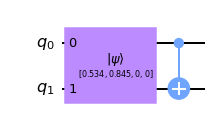

In [29]:
## Creamos circuito de 2 qubits
DemoCopiaCNOT = QuantumCircuit(2)
## Inicializamos el qubit de control
DemoCopiaCNOT.initialize(reg_st)
## Incluimos compuerta CNOT
DemoCopiaCNOT.cx(0,1)
## Dibujamos el circuito
DemoCopiaCNOT.draw(output='mpl')

/Users/diegoherrerarojas/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


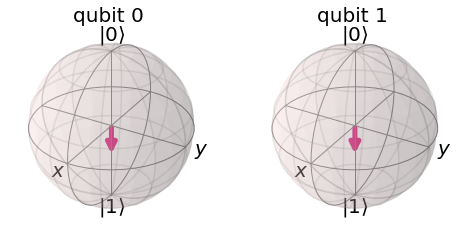

In [30]:
## Simulamos el circuito entrelazado
copia_CNOT = execute(DemoCopiaCNOT,backend).result().get_statevector()
## Dibujamos los vectores de bloch
plot_bloch_multivector(copia_CNOT)

Vemos que, si bien ambos qubits se encuentran en el mismo estado, el vector de Bloch se encuentra dentro de la esfera. En general, esta es una mala máquina copiadora, puesto que la *fidelidad* de la copia depende del estado a copiar. De hecho, si notamos esta cantidad con $F$, se tiene que

$$F = \cos^4{\frac{\theta}{2}} + \sin^4{\frac{\theta}{2}} \leq 1$$

Un copiador ideal tendría una fidelidad $F = 1$, *para todo estado de un qubit*. Sin embargo, esto está prohibido por el teorema de no clonación. Ahora veremos cómo podremos individualizar los qubits de un registro, incluso si están en un estado entrelazado. Y veremos cómo definir matemáticamente la fidelidad de un copiador cuántico.

#### Traza parcial

Cuando discutamos en más detalle el tratamiento de la medición de un registro cuántico veremos la lógica detrás del uso de la traza parcial. Por el momento, es suficiente establecer que en un sistema de varios qubits, podremos expresar un operador de densidad del registro por medio de una matriz. Si el registro contiene $N$ qubits, este se representará por medio de una matriz $2^{N}$-dimensional. En forma compacta, podremos representar este operador de la forma

$$\hat{\rho} = \sum_{k = 0}^{2^{N}-1} \sum_{m = 0}^{2^{N}-1} \rho_{km}|k\rangle\langle m|$$

Para un sistema de dos qubits, por ejemplo

$$|1\rangle\langle 2| = \begin{bmatrix}0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}$$

Por facilidad, representaremos los números en **sistema binario**. De esta forma

$$\hat{\rho} = \sum_{q_{N-1} = 0}^{1} \cdots \sum_{q_0 = 0}^{1}\sum_{q'_{N-1} = 0}^{1} \cdots \sum_{q'_0 = 0}^{1}  \rho_{q_{N-1}\cdots q_0,q'_{N-1}\cdots q'_0}|q_{N-1}\cdots q_0\rangle\langle q'_{N-1}\cdots q'_0|$$

Donde $q_{N-1}\cdots q_0$ representa un número entero en sistema binario. Definimos el **operador densidad reducido** correspondiente a un qubit $i$-ésimo del registro como

$$\hat{\rho}^{(i)} = \sum_{q_i = 0}^{1}\sum_{q'_i = 0}^{1} \rho^{(j)}_{q_iq'_i} |q_i\rangle\langle q_i|$$

Teniendo en cuenta que

$$\rho^{(j)}_{t_it'_i} = \sum_{q}\sum_{q'}  \rho_{q,q'} = \sum_{q_{N-1} = 0}^{1} \cdots \sum_{q_0 = 0}^{1} \rho_{q_{N-1}\cdots t_i \cdots q_0,q_{N-1}\cdots t'_i \cdots q_0}$$

**SUPER IMPORTANTE:** En las suma anterior, $q$ y $q'$ son cadenas binarias tales que $q_i = t_i$ y $q_i = t'_i$. Y son idénticas en el resto de bits.

Vamos a ver un ejemplo con un estado de la forma

$$|\Phi\rangle = \alpha|00\rangle + \beta|11\rangle$$

El operador densidad del sistema completo corresponde a

$$\hat{\rho} = (\alpha|00\rangle + \beta|11\rangle)(\alpha^{*}\langle 00| + \beta^{*}\langle 11|)$$

Para encontrar el operador densidad del qubit más significativo, simplemente debemos sumar los elementos matriciales que acompañan los *ketbras* $|i0\rangle\langle j0|$ y $|i1\rangle\langle j1|$, para valores de $i$ y $j$ dados. Así, invitamos al lector a demostrar que el operador densidad reducido del qubit más significativo es:

$$\hat{\rho}^{(1)} = |\alpha|^2|0\rangle\langle 0| + |\beta|^2|1\rangle\langle 1|$$

De igual manera, el operador densidad reducido del qubit menos significativo es

$$\hat{\rho}^{(1)} = |\alpha|^2|0\rangle\langle 0| + |\beta|^2|1\rangle\langle 1|$$

#### Fidelidad de un copiador

Un copiador ideal de un qubit, capaz de realizar la transformación

$$\hat{U}|\psi\rangle \otimes |Q\rangle \rightarrow |\psi\rangle \otimes |\psi\rangle$$

Está prohibido por el teorema de no clonación. Sin embargo, podremos definir **copiadores imperfectos**, que actúan sobre un registro de 2 o más qubits, y realizan transformaciones del estilo

$$\hat{U}|\psi\rangle \otimes |Q\rangle \rightarrow |R\rangle$$

En donde el estado $|R\rangle$ es tal que existen 2 qubits cuyos operadores densidad reducidos son idénticos

$$\hat{\rho}^{(i)} = \hat{\rho}^{(j)} = \hat{\rho}_R$$

> Un copiador es un dispositivo que toma un registro cuántico, en el cual un qubit se encuentra separado y en un estado arbitrario, y produce un estado final el el cual el operador densidad reducido de dos qubits es idéntico.

El estado $|Q\rangle$ es un estado auxiliar, el cual se va a inicializar en unos qubits de ancila. El estado $|\psi\rangle$ será el del qubit que deseamos copiar. Definiremos la **fidelidad de un copiador** por medio del valor esperado

$$F = \langle \psi| \hat{\rho}_R | \psi\rangle = \begin{bmatrix}\alpha^{*} & \beta^{*}\end{bmatrix} \begin{bmatrix}\rho_{00} & \rho_{01} \\ \rho_{10} & \rho_{11}\end{bmatrix} \begin{bmatrix}\alpha \\ \beta\end{bmatrix}$$

Invitamos al lector a mostrar que esta expresión es consistente con la que hemos reportado anteriormente para la compuerta CNOT como máquina copiadora.

En resumen, una máquina copiadora está determinada por

1. Un estado auxiliar de un subregistro de ancila que nos permitirá generar la copia
1. Un estado final que tendrá la propiedad que dos qubits tendrán el mismo operador densidad reducido.

## Copiador de Buzek y Hillery

Este fue propuesto por mencionados físicos en 1997. Su propuesta tiene dos características de gran importancia

1. La fidelidad del operador es independiente del estado a copiar
1. La fidelidad del copiador es la máxima posible

Representamos la máquina por medio de un circuito cuántico que consta de dos fases: 1) Preparación del estado auxiliar $|Q\rangle$ y 2) Transformación de copiado.

### Preparación del estado auxiliar

De acuerdo con Buzek y Hillery, el estado auxiliar óptimo es

$$|Q\rangle = \frac{1}{\sqrt{6}}(2|00\rangle + |01\rangle + |11\rangle)$$

En la primera fase de la máquina, prepararemos este estado utilizando rotaciones de un qubit alrededor del eje $y$, $R_y(2\theta_i)$, con ángulos

$$\cos{2\theta_1} = \frac{1}{\sqrt{5}}$$

$$\cos{2\theta_2} = \frac{\sqrt{5}}{3}$$

$$\cos{2\theta_3} = \frac{2}{\sqrt{5}}$$

Primero definimos los ángulos de rotación

In [4]:
## Parametros de la red de copiado
theta1 = np.arccos(1.0/np.sqrt(5))
theta2 = np.arccos(np.sqrt(5)/3)
theta3 = np.arccos(2/np.sqrt(5))

Ahora implementamos el circuito de preparación

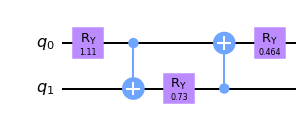

In [5]:
## Demostracion de la fase de preparacion
prep = QuantumCircuit(2)
## Aplicamos rotacion theta1
prep.ry(theta1,0)
## Aplicamos CNOT
prep.cx(0,1)
## Aplicamos rotacion theta2
prep.ry(theta2,1)
## Aplicamos CNOT
prep.cx(1,0)
## Aplicamos rotacion theta3
prep.ry(theta3,0)
## Dibujamos el circuito
prep.draw(output='mpl')

Por completez, reproducimos el estado auxiliar.

In [6]:
## Simulamos el estado final
PHI = execute(prep,backend).result().get_statevector()
## Imprimimos el resultado final
print(PHI)

[0.81649658+0.j 0.        +0.j 0.40824829+0.j 0.40824829+0.j]


Para poder realizar el copiador completo, convertiremos esta rutina de preparación en una subrutina.

In [7]:
paso_prep = prep.to_gate()
paso_prep.name = 'preparacion'

Inicializamos un circuito de 3 qubits. Los qubits 0 y 1 contendran el qubit original y su clon, respectivamente. El qubit 2 será un qubit auxiliar al cual no le daremos gran relevancia al final de la ejecución. Utilizaremos la rutina de inicialización para cargar el estado auxiliar $|Q\rangle$ en los qubits 1 y 2. Cargaremos un estado inicial arbitrario en el qubit 0.

In [8]:
## Definimos un estado inicial arbitrario
theta = np.pi/3
phi = np.pi/5
estado_a_copiar = np.array([
    np.cos(theta),
    np.exp(1j*np.pi)*np.sin(theta)
])

Incluimos una barrera para separar la fase de inicialización de la fase de copiado per se.

In [9]:
## Circuito de copiado
MaquinaCopiado = QuantumCircuit(3,1)
MaquinaCopiado.initialize(estado_a_copiar,0)

## Incluimos la fase de preparacion
MaquinaCopiado.append(paso_prep,[1,2])
## Colocamos una barrera por claridad
MaquinaCopiado.barrier()

## Construcción del circuito de copiado

La fase de copiado se implementa por medio de un conjunto de compuertas CNOT. Incluimos unas líneas de código en Pyhton que realizan esta tarea por medio de Qiskit.

In [10]:
## Incluimos la fase de copiado
MaquinaCopiado.cx(0,1)
MaquinaCopiado.cx(0,2)
MaquinaCopiado.cx(1,0)
MaquinaCopiado.cx(2,0)

Ahora dibujamos el circuito completo. Antes de la barrera está la fase de preparación del estado auxiliar. Después de la barrera está la fase de copiado.

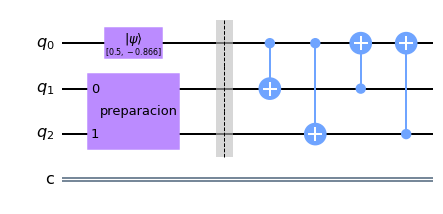

In [11]:
## Dibujamos circuito
MaquinaCopiado.draw(output='mpl')

Ahora procedemos a simualr el circuito y observar el estado de los dos primeros qubits en la esfera de Bloch

/Users/diegoherrerarojas/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


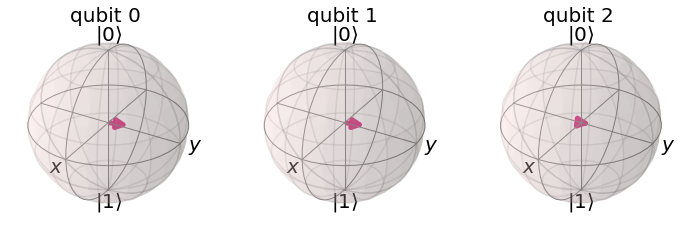

In [12]:
## Ejecutamos el circuito
estado_R = execute(MaquinaCopiado,backend).result().get_statevector()
## Dibujamos los estados en la esfera de Bloch
plot_bloch_multivector(estado_R)

Invitamos al lector a demostrar que el operador densidad reducido del qubit original y el de la copia es

$$\hat{\rho}_R = \frac{2}{3}|\psi\rangle\langle \psi| + \frac{1}{6}\hat{I}$$

De modo que la fidelidad de la máquina de Buzek y hillery es

$$F = \frac{5}{6}$$

Que además es la fidelidad más alta alcanzable por una máquina copiadora dentro de los límites del teorema de no clonación.

## Anexos

Incluimos unas líneas de código que permiten obtener el operador densidad reducido directamenter, en lugar de una visualización del vector de estado en la esfera de Bloch.

In [46]:
from qiskit.aqua.utils import get_subsystem_density_matrix

In [47]:
## Ejecutamos y simulamos el circuito
estado_final_registro = execute(MaquinaCopiado,backend).result().get_statevector()
## Imprimimos matriz densidad reducida primer qubit
rho0 = get_subsystem_density_matrix(estado_final_registro,[1,2])
print(rho0)

[[ 0.33333333+0.0000000e+00j -0.28867513-3.5352508e-17j]
 [-0.28867513+3.5352508e-17j  0.66666667+0.0000000e+00j]]


In [48]:
## Imprimimos matriz densidad reducida segundo qubit
rho0 = get_subsystem_density_matrix(estado_final_registro,[0,2])
print(rho0)

[[ 0.33333333+0.0000000e+00j -0.28867513-3.5352508e-17j]
 [-0.28867513+3.5352508e-17j  0.66666667+0.0000000e+00j]]


## Referencias

* Buzek y Hillery. Quantum copying: A network. Recuperdado de http://www.quantum.physics.sk/rcqi/mypapers/97pra3446.pdf
* Benti, Casati y Strini. Principles of Quantum COmputation and Information. Vols 1 y 2. World Scientific.
* Nielsen & Chuang. **Quantum Computation and Quantum Information**. Cambridge University Press, 2010.
* Beck. **Quantum Mechanics Theory and Experiments**. Cambridge University Press, 2012.
* Ataman. **The quantum optical description of a double Mach-Zehnder interferometer**. arXiv:1407.1704 [physics.optics]. 2014.
* Ekert. **From Interferometers to Quantum Computers**. Supplementary material, Mathematical Institute, University of Oxford, 2010.
* Wilde. **Quantum Information Theory**. Cambridge University Press, 2013.

Muchas gracias por leer esta publicación! Abajo se encuentran links a las lecciones siguientes en el Crash Course de QC-FEM.